El objetivo es trabajar con el dataset de imágenes de dígitos en manuscrita para identificar si el número es un 8 o no.

In [1]:
from sklearn import datasets

digits = datasets.load_digits()

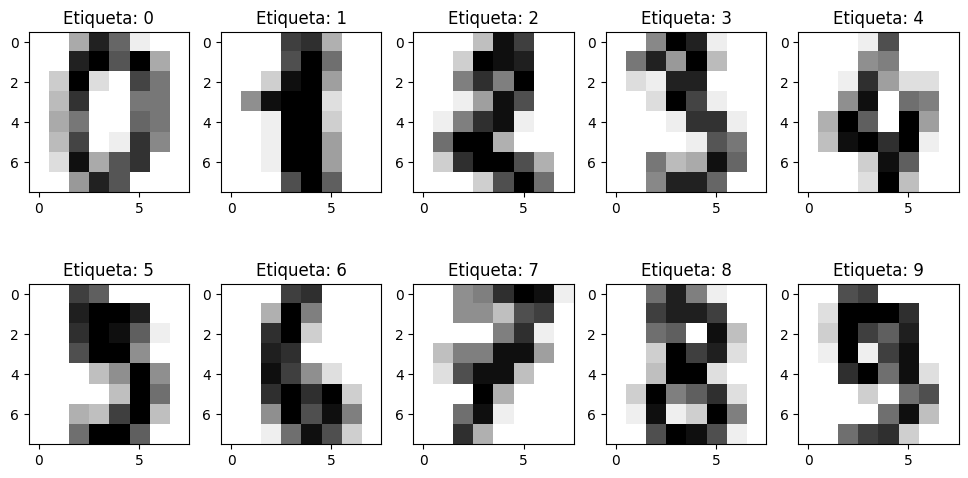

In [12]:
import matplotlib.pyplot as plt

# Obtener algunas imágenes y sus etiquetas
images_and_labels = list(zip(digits.images, digits.target))

# Ploteamos las primeras 10 imágenes
plt.figure(figsize=(12, 6))
for index, (image, label) in enumerate(images_and_labels[:10]):
    plt.subplot(2, 5, index + 1)
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Etiqueta: %i' % label)
plt.show()

In [2]:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target == 8
print(
    f"El número de imágenes es {X.shape[0]} y cada imagen contiene {X.shape[1]} píxeles"
)

El número de imágenes es 1797 y cada imagen contiene 64 píxeles


In [3]:
len(y[y==True]), len(y[y==False])

(174, 1623)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [5]:
### Para cada hiperparámetro se chequean las métricas de Precisión y Recall.

scores = ["precision", "recall"]

In [6]:
import pandas as pd


def print_dataframe(filtered_cv_results):
    ### print de los resultados de cross validation
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.7, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], "solver": ['newton-cg'], "max_iter": [200, 500]}
]

grid_search = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train_scaled, y_train)

All grid-search results:
precision: 0.951 (±0.041), recall: 0.695 (±0.055), for {'C': 0.1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.951 (±0.041), recall: 0.695 (±0.055), for {'C': 0.1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.563 (±0.061), recall: 0.877 (±0.069), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.563 (±0.061), recall: 0.877 (±0.069), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.882 (±0.117), recall: 0.756 (±0.038), for {'C': 1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.882 (±0.117), recall: 0.756 (±0.038), for {'C': 1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.646 (±0.094), recall: 0.842 (±0.072), for {'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.646 (±0.094), recall: 0.842 (±0.072), for {'C': 1, 'cl

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [200, 500], 'solver': ['newton-cg']}],
             refit=<function refit_strategy at 0x79ef3195d6c0>,
             scoring=['precision', 'recall'])

In [8]:
grid_search.best_params_

{'C': 1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}

In [9]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98       807
        True       0.89      0.67      0.77        92

    accuracy                           0.96       899
   macro avg       0.92      0.83      0.87       899
weighted avg       0.96      0.96      0.96       899



https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py

## Comparación de Métodos

In [14]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time

In [15]:
# Cargamos el conjunto de datos Iris
iris = load_iris()
X = iris.data
y = iris.target

# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# Creamos el clasificador RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

In [17]:
# Entrenamos el modelo sin optimización de hiperparámetros
start = time.time()
rf.fit(X_train, y_train)
end = time.time()
no_opt_time = end - start
y_pred_no_opt = rf.predict(X_test)

# Métricas para el modelo sin optimización
no_opt_accuracy = accuracy_score(y_test, y_pred_no_opt)
no_opt_precision = precision_score(y_test, y_pred_no_opt, average='weighted')
no_opt_recall = recall_score(y_test, y_pred_no_opt, average='weighted')
no_opt_f1_score = f1_score(y_test, y_pred_no_opt, average='weighted')

In [25]:
# Definimos los parámetros para Grid Search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Realizamos la búsqueda de hiperparámetros con Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
start = time.time()
grid_search.fit(X_train, y_train)
end = time.time()
grid_search_time = end - start
y_pred_grid_search = grid_search.predict(X_test)

# Métricas para el modelo con Grid Search
grid_search_accuracy = accuracy_score(y_test, y_pred_grid_search)
grid_search_precision = precision_score(y_test, y_pred_grid_search, average='weighted')
grid_search_recall = recall_score(y_test, y_pred_grid_search, average='weighted')
grid_search_f1_score = f1_score(y_test, y_pred_grid_search, average='weighted')

In [23]:
# Definimos los parámetros para Random Search
random_param_grid = {
    'n_estimators': np.arange(50, 100, 200),
    'max_depth': np.arange(5, 10, 20),
    'min_samples_split': np.arange(2, 5, 10),
    'min_samples_leaf': np.arange(1, 2, 4)
}

# Realizamos la búsqueda de hiperparámetros con Random Search
random_search = RandomizedSearchCV(estimator=rf, param_distributions=random_param_grid, n_iter=100, cv=5, random_state=42, n_jobs=-1)
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()
random_search_time = end - start
y_pred_random_search = random_search.predict(X_test)

# Métricas para el modelo con Random Search
random_search_accuracy = accuracy_score(y_test, y_pred_random_search)
random_search_precision = precision_score(y_test, y_pred_random_search, average='weighted')
random_search_recall = recall_score(y_test, y_pred_random_search, average='weighted')
random_search_f1_score = f1_score(y_test, y_pred_random_search, average='weighted')


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [28]:
# Creamos una tabla comparativa
results = pd.DataFrame({
    'Modelo': ['Sin Optimización', 'Grid Search', 'Random Search'],
    'Tiempo de Entrenamiento (s)': [no_opt_time, grid_search_time, random_search_time]
})

# Aplicar formato a la tabla
styled_results = results.style.format({
    'Accuracy': "{:.2%}",
    'Precision': "{:.2%}",
    'Recall': "{:.2%}",
    'F1 Score': "{:.2%}",
    'Tiempo de Entrenamiento (s)': "{:.2f}"
})

# Imprimir la tabla
styled_results.set_properties(**{'text-align': 'center'}).set_table_styles([{
    'selector': 'th',
    'props': [('text-align', 'center')]
}])


,Modelo,Tiempo de Entrenamiento (s)
0,Sin Optimización,0.26
1,Grid Search,78.59
2,Random Search,4.70
